In [ ]:
# Standard libraries
import os
import json
import sqlite3
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np
imporrt re

from sams.config import datasets
from sams.utils import load_data

from sams.preprocessing.iti_diploma_nodes import _fix_qual_names

from IPython.display import display_html

import duckdb
import importlib
import sams.utils
importlib.reload(sams.utils)  
from sams.utils import decrypt_roll

import re

2025-09-25 13:30:22.122 | INFO     | sams.config:<module>:15 - PROJ_ROOT path is: C:\Users\Admin\Documents\GitHub\sams
2025-09-25 13:30:22.178 | WARNING  | sams.config:<module>:83 - Google MAPS API key not found, using Nominatim geocoder
2025-09-25 13:30:22.178 | INFO     | sams.config:<module>:92 - Loaded 0 geocodes from cache


In [2]:
# Function to show column names of a table
db_path = datasets["sams"]["path"]
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

def describe_table(table_name):
    try:
        print(f"\nVariable of the table: {table_name}")
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        for col in columns:
            print(f"{col[1]} ({col[2]})")
    except sqlite3.Error as e:
        print(f"Error describing table {table_name}: {e}")


# Describe both tables
describe_table("students")

conn.close()


Variable of the table: students
id (INTEGER)
barcode (VARCHAR)
student_name (VARCHAR)
gender (VARCHAR)
religion_name (VARCHAR)
dob (VARCHAR)
nationality (VARCHAR)
annual_income (VARCHAR)
address (VARCHAR)
state (VARCHAR)
district (VARCHAR)
block (VARCHAR)
pin_code (VARCHAR)
social_category (VARCHAR)
domicile (VARCHAR)
s_domicile_category (VARCHAR)
outside_odisha_applicant_state_name (VARCHAR)
odia_applicant_living_outside_odisha_state_name (VARCHAR)
residence_barcode_number (VARCHAR)
tenth_exam_school_address (VARCHAR)
eighth_exam_school_address (VARCHAR)
highest_qualification_exam_board (VARCHAR)
board_exam_name_for_highest_qualification (VARCHAR)
highest_qualification (VARCHAR)
had_two_year_full_time_work_exp_after_tenth (VARCHAR)
gc (VARCHAR)
ph (VARCHAR)
es (VARCHAR)
sports (VARCHAR)
national_cadet_corps (VARCHAR)
pm_care (VARCHAR)
orphan (VARCHAR)
income_barcode (VARCHAR)
tfw (VARCHAR)
ews (VARCHAR)
boc (VARCHAR)
boc_regd_no (VARCHAR)
course_name (VARCHAR)
course_period (VARCHAR)

In [3]:
def process_students_exploded(db_path, module):
    con = duckdb.connect()
    con.execute(f"ATTACH DATABASE '{db_path}' AS sqlite_db (TYPE SQLITE)")

    query = f"""
    SELECT
        s.id,
        s.academic_year,
        s.barcode,
        s.aadhar_no,
        s.student_name,
        s.dob,
        s.highest_qualification,
        json_extract(j.value, '$.YearofPassing') AS year_of_passing,
        json_extract(j.value, '$.RollNo') AS roll_no,
        json_extract(j.value, '$.ExaminationType') AS examination_type,

        json_extract(j.value, '$.HighestQualificationExamBoard') AS HighestQualificationExamBoard
    FROM sqlite_db.students s,
         json_each(s.mark_data) j
    WHERE s.module = '{module}'
    """
    df = con.execute(query).df()
    con.close()
    return df

In [4]:
deg_enrollments = load_data(datasets["deg_enrollments"]) 
hss_enrollments = load_data(datasets["hss_enrollments"])

2025-09-25 13:30:25.049 | INFO     | sams.utils:load_data:75 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\deg_enrollments.pq
2025-09-25 13:31:12.440 | INFO     | sams.utils:load_data:75 - Loading data from C:\Users\Admin\Documents\GitHub\sams\data\interim\hss_enrollments.pq


In [7]:
# deg =  load_data(datasets["deg_applications"])
# deg2  =  load_data(datasets["deg_marks"])  

In [5]:
deg_enrollments.shape

(2054491, 32)

In [46]:
deg.columns

Index(['barcode', 'aadhar_no', 'academic_year', 'year', 'phase',
       'reported_institute', 'sams_code', 'institute_district',
       'institute_block', 'type_of_institute', 'stream', 'subject',
       'option_no', 'admission_status', 'num_applications'],
      dtype='object')

In [ ]:
deg2.shape

(2064490, 16)

In [47]:
deg2.columns

Index(['barcode', 'aadhar_no', 'board_exam_name_for_highest_qualification',
       'highest_qualification', 'module', 'academic_year',
       'examination_board_of_the_highest_qualification', 'examination_type',
       'year_of_passing', 'total_marks', 'secured_marks', 'percentage',
       'compartmental_status', 'comp_subject', 'comp_fail_mark',
       'comp_pass_mark'],
      dtype='object')

In [6]:
# Example usage
db_path = datasets["sams"]["path"]

iti_enrollments = process_students_exploded(db_path, "ITI")
diploma_enrollments = process_students_exploded(db_path, "Diploma")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
diploma_enrollments.head()

,id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,year_of_passing,roll_no,examination_type,HighestQualificationExamBoard
0,7964322,2018,18P000811,47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=,ALHAN HEMBRAM,02-Jun-1987,NA,"""2003""","""BuhIyrjuQSfebpl8Lt94NA==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
1,8018854,2018,18P614748,4TsXN+fmsO1desjdzI5V7tpxUz8LPRPfwQdzzmHSpVA=,MOHAMMAD TAHESEEM RAZA,03-Dec-2002,NA,"""2018""","""a/b/8P12DXi+GRGwfcyFuw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
2,7964344,2018,18P001063,4TsXN+fmsO1desjdzI5V7tpxUz8LPRPfwQdzzmHSpVA=,MOHAMMAD TAHESEEM RAZA,03-Dec-2002,NA,"""2018""","""a/b/8P12DXi+GRGwfcyFuw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
3,7964346,2018,18P001108,O4CFC4rKlFc7MNXL0zE0KDrALLK0vbm6b9wYAtxuaEI=,Banambar Behera,24-May-1995,NA,"""2010""","""knHW0DhZJK/LgeHmjzpg7w==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
4,7964346,2018,18P001108,O4CFC4rKlFc7MNXL0zE0KDrALLK0vbm6b9wYAtxuaEI=,Banambar Behera,24-May-1995,NA,"""2012""","""X9yMEgED2jVm9ImEZc+IaQ==""","""Annual""","""Council of Higher Secondary Education, Odisha..."


In [6]:
diploma_enrollments.head()

,id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,year_of_passing,roll_no,examination_type,HighestQualificationExamBoard
0,7964322,2018,18P000811,47DEQpj8HBSa+/TImW+5JCeuQeRkm5NMpJWZG3hSuFU=,ALHAN HEMBRAM,02-Jun-1987,NA,"""2003""","""BuhIyrjuQSfebpl8Lt94NA==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
1,8018854,2018,18P614748,4TsXN+fmsO1desjdzI5V7tpxUz8LPRPfwQdzzmHSpVA=,MOHAMMAD TAHESEEM RAZA,03-Dec-2002,NA,"""2018""","""a/b/8P12DXi+GRGwfcyFuw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
2,7964344,2018,18P001063,4TsXN+fmsO1desjdzI5V7tpxUz8LPRPfwQdzzmHSpVA=,MOHAMMAD TAHESEEM RAZA,03-Dec-2002,NA,"""2018""","""a/b/8P12DXi+GRGwfcyFuw==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
3,7964346,2018,18P001108,O4CFC4rKlFc7MNXL0zE0KDrALLK0vbm6b9wYAtxuaEI=,Banambar Behera,24-May-1995,NA,"""2010""","""knHW0DhZJK/LgeHmjzpg7w==""","""Annual""","""Board of Secondary Education, Odisha, Cuttack..."
4,7964346,2018,18P001108,O4CFC4rKlFc7MNXL0zE0KDrALLK0vbm6b9wYAtxuaEI=,Banambar Behera,24-May-1995,NA,"""2012""","""X9yMEgED2jVm9ImEZc+IaQ==""","""Annual""","""Council of Higher Secondary Education, Odisha..."


In [7]:
# Final schema across all modules
FINAL_SCHEMA = [
    "sams_id", 
    "academic_year", 
    "barcode", 
    "aadhar_no",
    "student_name", 
    "dob",
    "highest_qualification", 
    "passing_year", 
    "roll_no",
    "examination_type",
    "exam_board_name_of_highest_qual"
]

# Base mappings 
BASE_ITI_DIP = {
    "id": "sams_id",
    "YearofPassing": "passing_year",
    "RollNo": "roll_no",
    "HighestQualificationExamBoard": "exam_board_name_of_highest_qual",
}

BASE_DEG_HSS = {
    "id": "sams_id",
    "year_of_passing": "passing_year",
    "examination_board_of_the_highest_qualification": "exam_board_name_of_highest_qual",
}

# Centralized rename maps by module
RENAME_MAPS = {
    "iti": BASE_ITI_DIP,
    "diploma": BASE_ITI_DIP,
    "deg": BASE_DEG_HSS,
    "hss": BASE_DEG_HSS,
}

In [8]:
def clean_sams_dataset(df: pd.DataFrame, module: str) -> pd.DataFrame:
    """
    Clean and standardize SAMS datasets to a common schema.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw dataframe for a given module.
    module : str
        Module name: "iti", "diploma", "deg", "hss".
    
    Returns
    -------
    pd.DataFrame
        Cleaned dataframe with FINAL_SCHEMA applied.
    """
    module = module.lower()

    # Rename using module-specific mapping
    rename_map = RENAME_MAPS.get(module, {})
    df = df.rename(columns=rename_map)

    # Add missing columns with NA (vectorized)
    missing_cols = [col for col in FINAL_SCHEMA if col not in df.columns]
    if missing_cols:
        df[missing_cols] = pd.NA

    # Subset + reorder
    return df[FINAL_SCHEMA]

In [9]:
iti_df = clean_sams_dataset(iti_enrollments, "iti")
diploma_df = clean_sams_dataset(diploma_enrollments, "diploma")
hss_df = clean_sams_dataset(hss_enrollments, "hss")
deg_df = clean_sams_dataset(deg_enrollments, "deg")

In [ ]:
# to build copy datatset without applying any condition on roll numbers 
deg_df_copy = deg_df.copy()

# Add decrypted roll numbers in a new column (raw, no conditions)
deg_df_copy['roll_no_original_decrypt'] = deg_df_copy['roll_no'].map(decrypt_roll)


In [10]:
# code for decryption
from base64 import b64decode
from Crypto.Cipher import AES

def decrypt_roll(enc_text: str,
                 key: bytes = b"y6idXfCVRG5t2dkeBnmHy9jLu6TEn5Du",
                 enforce_min_length: bool = False,
                 min_length: int = None) -> str:
    try:
        if not enc_text or not isinstance(enc_text, str):
            return "NA"

        raw = b64decode(enc_text)
        cipher = AES.new(key, AES.MODE_ECB)
        decrypted = cipher.decrypt(raw)

        pad_len = decrypted[-1]
        if pad_len < 1 or pad_len > 16:
            return "NA"
        decrypted = decrypted[:-pad_len]

        roll_no = decrypted.decode("utf-8").strip()
        return roll_no
    except Exception:
        return "NA"    

In [9]:
def process_roll_numbers(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:    
    """
    Decrypt roll numbers and replace conflicted rolls (multiple Aadhaar for same year & board) with 'NA'.
    Returns the DataFrame with an added 'roll_no_decrypted' column

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with roll numbers and Aadhaar info.
    roll_col : str
        Column containing the encrypted roll numbers.

    Returns
    -------
    pd.DataFrame
        DataFrame with an additional 'roll_no_decrypted' column and conflicts handled.
    """
    # Decrypt roll numbers directly into existing DataFrame
    df.loc[:, 'roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Filter out rows with non-empty Aadhaar only (we ignore empty/missing for conflict check)
    valid_rows = df['aadhar_no'].astype(str).str.strip().replace('', np.nan).notna()

    # Group by roll_no_decrypted only where Aadhaar is valid
    grouped = df.loc[valid_rows].groupby('roll_no_decrypted', sort=False).agg(
        aadhar_count=('aadhar_no', lambda x: x.astype(str).str.strip().nunique()),
        year_count=('academic_year', 'nunique'),
        board_count=('exam_board_name_of_highest_qual', 'nunique')
    )

    # Roll numbers with conflict: multiple Aadhaar for same year & board
    conflicted_rolls = grouped.loc[
        (grouped['aadhar_count'] > 1) &
        (grouped['year_count'] == 1) &
        (grouped['board_count'] == 1)
    ].index

    # Replace conflicted roll numbers with 'NA' directly
    df.loc[df['roll_no_decrypted'].isin(conflicted_rolls), 'roll_no_decrypted'] = 'NA'

    return df

In [ ]:
iti_df = process_roll_numbers(iti_df)
diploma_df = process_roll_numbers(diploma_df)
hss_df = process_roll_numbers(hss_df)
deg_df = process_roll_numbers(deg_df)

In [10]:
def process_roll_numbers_duckdb(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:
    """
    Decrypt roll numbers and replace conflicted rolls (multiple Aadhaar for same year & board) with 'NA'.
    Returns the DataFrame with an added 'roll_no_decrypted' column

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with roll numbers and Aadhaar info.
    roll_col : str
        Column containing the encrypted roll numbers.

    Returns
    -------
    pd.DataFrame
        DataFrame with an additional 'roll_no_decrypted' column and conflicts handled.
    """
    # Decrypt roll numbers in a new column
    df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Create DuckDB in-memory connection
    con = duckdb.connect(database=':memory:')

    # Register DataFrame as a DuckDB table
    con.register('students', df)

    # SQL: consider only non-missing Aadhaar numbers for conflict check
    query = """
    WITH valid AS (
        SELECT roll_no_decrypted, aadhar_no, academic_year
        FROM students
        WHERE aadhar_no IS NOT NULL AND TRIM(aadhar_no) <> ''
    ),
    grouped AS (
        SELECT
            roll_no_decrypted,
            COUNT(DISTINCT aadhar_no) AS aadhar_count,
            COUNT(DISTINCT academic_year) AS year_count,
        FROM valid
        GROUP BY roll_no_decrypted
    ),
    conflicted AS (
        SELECT roll_no_decrypted
        FROM grouped
        WHERE aadhar_count > 1 AND year_count = 1 
    )
    SELECT roll_no_decrypted
    FROM conflicted
    """
    conflicted_rolls = con.execute(query).fetchall()
    conflicted_rolls = set(r[0] for r in conflicted_rolls)

    # Replace conflicted roll numbers with 'NA'
    df.loc[df['roll_no_decrypted'].isin(conflicted_rolls), 'roll_no_decrypted'] = 'NA'

    con.close()
    return df

In [ ]:
def process_roll_numbers_duckdb(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:
    """
    Decrypt roll numbers and replace conflicted rolls (multiple Aadhaar for same year & board) with 'NA',
    except for BSE, Odisha and CHSE, Odisha rolls which are kept as-is if decrypted.

    Returns the DataFrame with an added 'roll_no_decrypted' column.
    """

    # Decrypt roll numbers into a new column
    df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Valid roll number regex (alphanumeric, min length 6)
    valid_pattern = re.compile(r'[A-Za-z0-9]{6,}')

    # --- Identify special-case rows (BSE/CHSE) ---
    mask_bse_chse = (
        df['exam_board_name_of_highest_qual'].str.contains(r'BSE|CHSE', case=False, na=False) |
        df['highest_qualification'].str.contains(r'BSE|CHSE', case=False, na=False)
    )

    # Create DuckDB in-memory connection
    con = duckdb.connect(database=':memory:')
    con.register('students', df)

    # Identify rolls linked to multiple Aadhaar for same academic year
    query_conflicted = """
    WITH valid AS (
        SELECT roll_no_decrypted, aadhar_no, academic_year,
               highest_qualification, exam_board_name_of_highest_qual
        FROM students
        WHERE aadhar_no IS NOT NULL AND TRIM(aadhar_no) <> ''
    ),
    grouped AS (
        SELECT
            roll_no_decrypted,
            academic_year,
            COUNT(DISTINCT aadhar_no) AS aadhar_count,
            MAX(CASE WHEN highest_qualification IS NULL OR TRIM(highest_qualification) = '' THEN 1 ELSE 0 END) AS missing_qual,
            MAX(CASE WHEN exam_board_name_of_highest_qual IS NULL OR TRIM(exam_board_name_of_highest_qual) = '' THEN 1 ELSE 0 END) AS missing_board
        FROM valid
        GROUP BY roll_no_decrypted, academic_year
        HAVING COUNT(DISTINCT aadhar_no) > 1
    )
    SELECT roll_no_decrypted, academic_year, missing_qual, missing_board
    FROM grouped;
    """
    conflicted_df = con.execute(query_conflicted).fetchdf()
    con.close()  # close connection early to save memory

    # Apply final NA logic in pandas
    if not conflicted_df.empty:
        for idx, row in conflicted_df.iterrows():
            roll = row['roll_no_decrypted']
            year = row['academic_year']
            mask = (df['roll_no_decrypted'] == roll) & (df['academic_year'] == year)

            for i in df.index[mask]:
                # Skip if BSE/CHSE (keep decrypted value as-is)
                if mask_bse_chse.iloc[i]:
                    continue  

                decrypted_roll = df.at[i, 'roll_no_decrypted']
                highest_qual_missing = row['missing_qual'] == 1
                board_missing = row['missing_board'] == 1

                if not valid_pattern.fullmatch(decrypted_roll) or highest_qual_missing or board_missing:
                    df.at[i, 'roll_no_decrypted'] = 'NA'

    return df


In [ ]:
def process_roll_numbers_duckdb(df: pd.DataFrame, roll_col: str = 'roll_no') -> pd.DataFrame:
    """
    Decrypt roll numbers and validate only for exact matches:
    - BSE, Odisha: length must be 9
    - CHSE, Odisha: length must be 8
    """

    # Decrypt roll numbers
    df['roll_no_decrypted'] = df[roll_col].map(decrypt_roll)

    # Normalize board/qualification names
    board_col = df['exam_board_name_of_highest_qual'].fillna("").str.strip().str.upper()
    qual_col  = df['highest_qualification'].fillna("").str.strip().str.upper()

    # Exact matches only
    mask_bse  = (board_col == "BSE, Odisha") | (qual_col == "BSE, Odisha")
    mask_chse = (board_col == "CHSE, Odish") | (qual_col == "CHSE, Odisha")

    # Apply validation
    rolls_bse = df.loc[mask_bse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
    valid_bse = rolls_bse.str.len() == 9
    df.loc[mask_bse & ~valid_bse, 'roll_no_decrypted'] = 'NA'

    rolls_chse = df.loc[mask_chse & df['roll_no_decrypted'].notna(), 'roll_no_decrypted'].astype(str)
    valid_chse = rolls_chse.str.len() == 8
    df.loc[mask_chse & ~valid_chse, 'roll_no_decrypted'] = 'NA'

    return df


In [20]:
iti_df = process_roll_numbers_len_format(iti_df)
diploma_df = process_roll_numbers_len_format(diploma_df)
hss_df = process_roll_numbers_len_format(hss_df)
deg_df = process_roll_numbers_len_format(deg_df)

In [21]:
key_vars = ["dob", "passing_year", "roll_no_decrypted", "exam_board_name_of_highest_qual"]

def generate_summary(df, key_vars):
    """
    Generate summary stats for key variables in a dataset and includes normalization of 'highest_qualification'.
    """

    summary = []
    for col in key_vars:
        total = df[col].count()
        unique_vals = df[col].nunique()
        missing = (
            df[col].isna().sum()
            + (df[col] == " ").sum()
            + df[col].isin(["NA", "na"]).sum()
        )
        summary.append({
            "variable": col,
            "total_rows": total,
            "unique_values": unique_vals,
            "missing_count": missing
        })
    return pd.DataFrame(summary)


iti_summary = generate_summary(iti_df, key_vars)
diploma_summary = generate_summary(diploma_df, key_vars)
deg_summary = generate_summary(deg_df, key_vars)
hss_summary = generate_summary(hss_df, key_vars)

tables = [
    iti_summary.style.set_caption("ITI Summary"),
    diploma_summary.style.set_caption("Diploma Summary"),
    hss_summary.style.set_caption("HSS Summary"),
    deg_summary.style.set_caption("DEG Summary")
]

# Stack vertically with spacing
html = "<br><br>".join([t._repr_html_() for t in tables])  # 2 blank lines between tables
display_html(html, raw=True)

,variable,total_rows,unique_values,missing_count
0,dob,559575,11007,0
1,passing_year,0,0,559575
2,roll_no_decrypted,559575,472970,67
3,exam_board_name_of_highest_qual,559575,53,0
,variable,total_rows,unique_values,missing_count
0,dob,558879,10126,0
1,passing_year,0,0,558879
2,roll_no_decrypted,558879,468284,1
3,exam_board_name_of_highest_qual,558879,97,0
,variable,total_rows,unique_values,missing_count


In [15]:
# If a function with the same name exists, remove it
try:
    duckdb.remove_function("decrypt_roll")
except Exception:
    pass  # Safe to ignore if not previously registered

# Wrapper for DuckDB
def decrypt_roll_duckdb(enc_text: str) -> str:
    return decrypt_roll(enc_text)  # passes only the encrypted text, rest use defaults

# Register wrapper in DuckDB
duckdb.create_function("decrypt_roll", decrypt_roll_duckdb, ["VARCHAR"], "VARCHAR")

In [16]:
dfs = {
    "iti": iti_df,
    "diploma": diploma_df,
    "hss": hss_df,
    "deg": deg_df,
}

new_dfs = {}

for name, df in dfs.items():
    # Register this DataFrame in DuckDB
    duckdb.register("df", df)

    # Query with the decrypt function to add new column
    new_dfs[name] = duckdb.query("""
        SELECT *, decrypt_roll(roll_no) AS roll_no_original_decrypt
        FROM df
    """).to_df()

    # Unregister to avoid conflicts in next loop
    duckdb.unregister("df")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
iti_dec_roll = new_dfs["iti"]
diploma_dec_roll = new_dfs["diploma"]
hss_dec_roll = new_dfs["hss"]
deg_dec_roll = new_dfs["deg"]

In [17]:
hss_dec_roll.head()

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board_name_of_highest_qual,roll_no_decrypted,roll_no_original_decrypt
0,<NA>,2018,18J0054157,,<NA>,07-Jul-2002,10TH,2018,OQpGykhOnzUDRJkE5xDqhA==,Annual,"BSE, Odisha",370AD0030,370AD0030
1,<NA>,2018,18J0054211,,<NA>,05-Dec-2002,10TH,2018,GGqv3Kdo8HZyK68MvPXQXg==,Annual,"BSE, Odisha",110EC0054,110EC0054
2,<NA>,2018,18J0054354,,<NA>,25-Aug-2003,10TH,2018,cHtLfCL89qhpsPRWMhcMCg==,Annual,"BSE, Odisha",170EA0132,170EA0132
3,<NA>,2018,18J0054431,,<NA>,20-Apr-2003,10TH,2018,0Cx1ngpH/vvmun5PtcC9yA==,Annual,"BSE, Odisha",040BB0008,040BB0008
4,<NA>,2018,18J0054684,,<NA>,20-Mar-2001,10TH,2018,d7usWOp/eZSqwAjwzjD4UA==,Annual,"BSE, Odisha",225EG0117,225EG0117


In [ ]:
deg_dec_roll.columns
deg_dec_roll

,sams_id,academic_year,barcode,aadhar_no,student_name,dob,highest_qualification,passing_year,roll_no,examination_type,exam_board_name_of_highest_qual,roll_no_decrypted,roll_no_original_decrypt
0,16526,2018,18D023830,,A/3AsPJNu6SmqSblSln3GP0QEID/kiP8ndDCBaMcSb8=,08-Oct-2000,+2 SCIENCE,2018,98w13QmDgMW+UXCnBK8O9w==,Annual,"CHSE, Odisha",397CA023,397CA023
1,11848,2018,18D017396,,CKYprJaNFo9F8dxfVVyJAPmAn2qMwnQGhTyiytskj+8=,30-Mar-2001,+2 ARTS,2018,FtTtUoGfY1x7UcEEGdU0GA==,Annual,"CHSE, Odisha",111BA132,111BA132
2,68864,2018,18D091129,,5k2Hfu6wtKVh6wgnEoy8eZ+NDaz6o/D/F7REbk5hBvM=,22-Oct-2000,+2 ARTS,2018,9v3VVLng8hIsGWeYCz12oQ==,Annual,"CHSE, Odisha",113MC089,113MC089
3,33506,2018,18D046216,,Fu0baNRZFXHRoQ2BptwXvn4ZQVkb6MQMrFyBwjdV2V0=,05-Mar-2001,+2 ARTS,2018,KYtMGaxdA+nNzUHtVQo5CQ==,Annual,"CHSE, Odisha",118CB017,118CB017
4,24105,2018,18D033856,,owJV5Kn/Ah53r8SOFq3R2G2byQDEErJ4Dj9YeNQHkbk=,01-Apr-2001,+2 COMMERCE,2018,a83EHOlG+HEAdH6/3SeuTg==,Annual,"CHSE, Odisha",203NC048,203NC048
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054486,1746352,2024,24D005221,None,IForkP3joSsuFy8Mj9P3H6YtfBovXdAdLpBKEd0UIvg=,16-Sep-2006,+2 SCIENCE,2024,CisWnZh3lFo+uDAjckyWLA==,Annual,"CHSE, Odisha",320MC064,320MC064
2054487,1746350,2024,24D005217,None,z0LRviLJtM+TTS/1lA3qDot/K+MGi9p1XpB0ahTRpeU=,08-Feb-2007,+2 ARTS,2024,ZZHaO5JH3n3pk/rNw2iGeA==,Annual,"CHSE, Odisha",108MB029,108MB029
2054488,1746349,2024,24D005215,None,QXW4zK3+Y/WB72EYVBCBw2oxCZxdSYYblSDvHN9YhZo=,30-Sep-2006,+2 ARTS,2024,xxj2dYGze/Kbezj8kuxFsg==,Annual,"CHSE, Odisha",115MA191,115MA191
2054489,1746348,2024,24D005213,None,FbtUbWIzLqQa+/1325Niebq9L59W1ayP/66NSL3z9ek=,15-Feb-2007,+2 ARTS,2024,IxtpmwgQBDHVrhW7zdxWzg==,Annual,"CHSE, Odisha",119cb010,119cb010


In [1]:
#count how many rows have NA instead of decrypted values
def summarize_counts(df, name):
    total = len(df)
    orig = df['roll_no_original_decrypt'].fillna("").str.strip() != ""
    invalid = ((df['roll_no_decrypted'] == "NA") & orig).sum()
    valid = ((df['roll_no_decrypted'] != "NA") & orig).sum()
    return {"module": name, "total_rows": total, "rows_with_NA": invalid, "valid_rows": valid}

results = [
    summarize_counts(iti_dec_roll, "ITI"),
    summarize_counts(diploma_dec_roll, "Diploma"),
    summarize_counts(hss_dec_roll, "HSS"),
    summarize_counts(deg_dec_roll, "Degree"),
]
pd.DataFrame(results)

NameError: name 'iti_dec_roll' is not defined

In [46]:
def roll_no_missing_summary(df, module_name):
    # group students and collect their roll numbers (excluding NA)
    student_summary = (
        df.groupby('aadhar_no')['roll_no_decrypted']
        .agg(lambda x: set([r for r in x if r != "NA"]))
        .reset_index(name="roll_set")
    )

    # categorize students
    students_no_roll = (student_summary['roll_set'].str.len() == 0).sum()
    students_one_roll = (student_summary['roll_set'].str.len() == 1).sum()
    students_multiple_rolls = (student_summary['roll_set'].str.len() > 1).sum()

    # compute gap between students and unique roll numbers
    total_students = len(student_summary)
    gap_students_minus_rolls = total_students - students_no_roll

    return {
        "module": module_name,
        "total_enrollments": len(df),                    # rows
        "total_students": total_students,                # Aadhaar unique
        "students_with_one_roll": students_one_roll,     # Aadhaar → 1 roll
        "students_without_roll": students_no_roll,       # Aadhaar → 0 roll
        "students_with_multiple_rolls": students_multiple_rolls, # Aadhaar → >1 roll
        "diff_total_students_count_vs_without_roll": gap_students_minus_rolls     # difference
    }


In [ ]:
diploma_df

In [ ]:
iti_summary = roll_no_missing_summary(iti_df, "ITI")
diploma_summary = roll_no_missing_summary(diploma_df, "Diploma")
hss_summary = roll_no_missing_summary(hss_df, "HSS")
deg_summary = roll_no_missing_summary(deg_df, "DEG")

In [ ]:
summary_df = pd.DataFrame([iti_summary, diploma_summary,hss_summary,  deg_summary])
summary_df

In [19]:
def roll_no_student_summary(df, module_name):
    # group students and collect their roll numbers 
    student_summary = (
        df.groupby('aadhar_no')['roll_no_decrypted']
        .agg(lambda x: set([r for r in x if r != "NA"]))
        .reset_index(name="roll_set")
    )

    total_students = len(student_summary)
    students_with_roll = (student_summary['roll_set'].str.len() > 0).sum()
    students_without_roll = (student_summary['roll_set'].str.len() == 0).sum()

    return {
        "module": module_name,
        "total_rows": len(df),                    
        "unique_aadhar": total_students,
        "students_count_with_unique_roll_numbers": students_with_roll,
        "students_count_with_missing_roll_numbers": students_without_roll
    }


In [20]:
iti_summary = roll_no_student_summary(iti_df, "ITI")
diploma_summary = roll_no_student_summary(diploma_df, "Diploma")
hss_summary = roll_no_student_summary(hss_df, "HSS")
deg_summary = roll_no_student_summary(deg_df, "DEG")
summary_df = pd.DataFrame([iti_summary, diploma_summary,hss_summary,  deg_summary])
summary_df

,module,total_rows,unique_aadhar,students_count_with_unique_roll_numbers,students_count_with_missing_roll_numbers
0,ITI,559575,518025,508361,9664
1,Diploma,558879,417756,409601,8155
2,HSS,3453401,2650770,2630577,20193
3,DEG,2054491,1506304,1493406,12898


In [21]:
def aadhar_diagnostics_all(db_path: str, table: str = "students") -> pd.DataFrame:
    """
    Run Aadhaar diagnostics for all modules from the students table in DuckDB,
    excluding PDIS and ordering ITI → Diploma → HSS → DEG.
    """
    con = duckdb.connect(database=':memory:')
    con.execute(f"ATTACH DATABASE '{db_path}' AS sams")

    query = f"""
    WITH cleaned AS (
        SELECT 
            module,
            aadhar_no,
            NULLIF(TRIM(CAST(aadhar_no AS VARCHAR)), '') AS aadhar_clean
        FROM sams.{table}
        WHERE module IN ('ITI', 'Diploma', 'HSS', 'DEG')  -- explicitly exclude PDIS
    )
    SELECT 
        module,
        COUNT(*) AS total_rows,
        COUNT(DISTINCT aadhar_clean) AS unique_aadhar,
        SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) AS missing_aadhar_rows,
        COUNT(*) - COUNT(DISTINCT aadhar_no) - SUM(CASE WHEN aadhar_clean IS NULL THEN 1 ELSE 0 END) 
            AS duplicate_aadhar_rows
    FROM cleaned
    GROUP BY module
    ORDER BY CASE module
        WHEN 'ITI' THEN 1
        WHEN 'Diploma' THEN 2
        WHEN 'HSS' THEN 3
        WHEN 'DEG' THEN 4
    END;
    """

    result = con.execute(query).df()
    con.close()
    return result

db_path = datasets["sams"]["path"]
aadhar_diag = aadhar_diagnostics_all(db_path)
aadhar_diag

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,module,total_rows,unique_aadhar,missing_aadhar_rows,duplicate_aadhar_rows
0,ITI,559575,518025,0.0,41550.0
1,Diploma,477605,417756,0.0,59849.0
2,HSS,3453401,2650769,422002.0,380629.0
3,DEG,2054491,1506304,144701.0,403485.0


In [ ]:
# 2. Duplicate Aadhaar summary
missing_mask = hss_df['aadhar_no'].isna() | (hss_df['aadhar_no'].astype(str).str.strip() == "")
non_missing = hss_df.loc[~missing_mask, 'aadhar_no']
freq = non_missing.value_counts()

duplicates_df = freq[freq > 1].reset_index()
duplicates_df.columns = ['aadhar_no', 'count']
print("\n=== Duplicate Aadhaar Summary ===")
display(duplicates_df.head())
duplicates_df  


=== Duplicate Aadhaar Summary ===


,aadhar_no,count
0,V-JºLÁx4\tÌ2yl;C»ghÌUå MÓ§æ\µ\$Š,29
1,MIN—©z·5D7ÄÈ”¢Êì<öÞ99Mq`‘¨@ ±,20
2,˜…H¤MÁŽ ž“®¬pþ5\n)¼‰Cø1„Ûñê,18
3,â&¢0ï».:»¾òbÜ>`Õ`ÑOñÜûN|\t-èZ’áË|,17
4,V©]C ï‚¦?j›¶§Qp oƒåO Ú´©òˆ,13


In [ ]:
# 1. Missing Aadhaar rows (NA or blank)
missing_mask = hss_df['aadhar_no'].isna() | (hss_df['aadhar_no'].astype(str).str.strip() == "")
missing_df = hss_df[missing_mask]
print("=== Missing Aadhaar Rows ===")
display(missing_df.head())  # show first 20 for inspection

missing_df

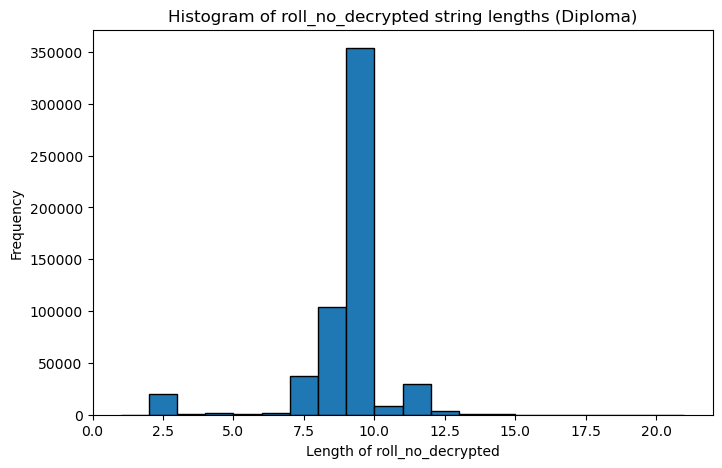

In [ ]:
import matplotlib.pyplot as plt
# built the histogram to check the string lenghth of roll no decrypted for diploma_df
# Calculate string lengths
lengths = iti_df["roll_no_decrypted"].astype(str).str.len()

plt.figure(figsize=(8, 5))
plt.hist(lengths, bins=range(lengths.min(), lengths.max() + 2), edgecolor='black')
plt.xlabel("Length of roll_no_decrypted")
plt.ylabel("Frequency")
plt.title("Histogram of roll_no_decrypted string lengths (Diploma)")
plt.show()

In [ ]:
# add the logic to understand the roll no is inconsistent or invalid regardless it is decrypted to something

In [ ]:
deg_df_new

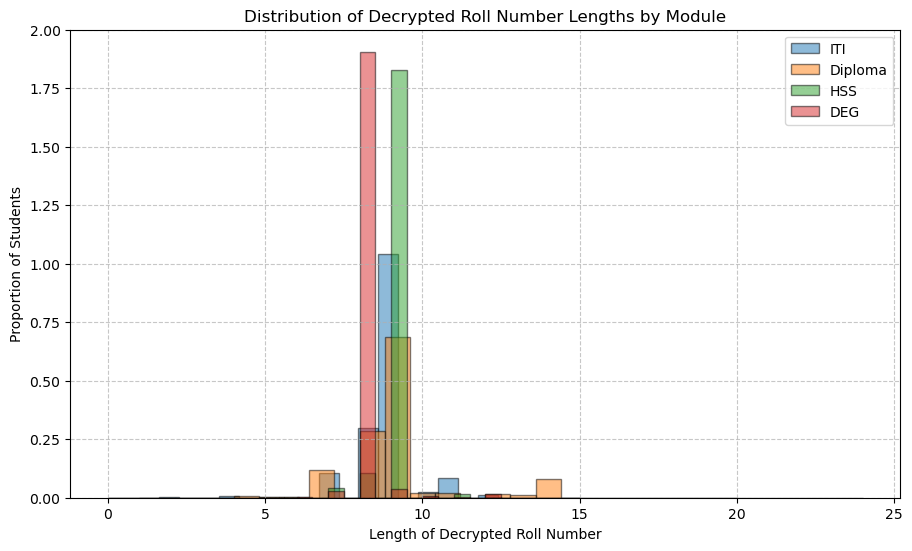

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Compute decrypted roll number lengths for each module
lengths_data = {
    "ITI": iti_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "Diploma": diploma_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "HSS": hss_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
    "DEG": deg_df_copy['roll_no_original_decrypt'].astype(str).str.len(),
}

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each module's length distribution as a histogram
for label, lengths in lengths_data.items():
    ax.hist(lengths, bins=30, alpha=0.5, label=label, edgecolor="black", density=True)

# Formatting
ax.set_title("Distribution of Decrypted Roll Number Lengths by Module")
ax.set_xlabel("Length of Decrypted Roll Number")
ax.set_ylabel("Proportion of Students")

# Set Y-axis ticks (e.g., 0%, 2%, ..., 10%)
yticks = np.arange(0, 0.12, 0.02)
# ax.set_yticks(yticks)
# ax.set_yticklabels([f"{int(y * 100)}%" for y in yticks])

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Add margin to avoid clipping left side
plt.subplots_adjust(left=0.12, right=0.95, top=0.9, bottom=0.12)

plt.show()


In [ ]:
print((diploma_df["roll_no_decrypted"].str.len() <= 3).sum())

156


In [ ]:
print("ITI shape:", iti_df.shape)
print("Diploma shape:", diploma_df.shape)
print("HSS shape:", hss_df.shape)
print("DEG shape:", deg_df.shape)

ITI shape: (559575, 10)
Diploma shape: (558879, 10)
HSS shape: (3453401, 10)
DEG shape: (2054491, 10)


In [ ]:
iti_df.columns

Index(['sams_id', 'academic_year', 'barcode', 'aadhar_no', 'dob',
       'highest_qualification', 'passing_year', 'roll_no',
       'exam_board_name_of_highest_qual', 'roll_no_decrypted'],
      dtype='object')

In [ ]:
key_vars = ["student_name", "dob", "passing_year", "roll_no_decrypted", "examination_type", "exam_board_name_of_highest_qual"]

def generate_summary(df, key_vars):
    """
    Generate summary stats for key variables in a dataset and includes normalization of 'highest_qualification'.
    """

    summary = []
    for col in key_vars:
        total = df[col].count()
        unique_vals = df[col].nunique()
        missing = (
            df[col].isna().sum()
            + (df[col] == " ").sum()
            + df[col].isin(["NA", "na"]).sum()
        )
        summary.append({
            "variable": col,
            "total_rows": total,
            "unique_values": unique_vals,
            "missing_count": missing
        })
    return pd.DataFrame(summary)


iti_summary = generate_summary(iti_df, key_vars)
diploma_summary = generate_summary(diploma_df, key_vars)
deg_summary = generate_summary(deg_df, key_vars)
hss_summary = generate_summary(hss_df, key_vars)

tables = [
    iti_summary.style.set_caption("ITI Summary"),
    diploma_summary.style.set_caption("Diploma Summary"),
    hss_summary.style.set_caption("HSS Summary"),
    deg_summary.style.set_caption("DEG Summary")
]

# Stack vertically with spacing
html = "<br><br>".join([t._repr_html_() for t in tables])  # 2 blank lines between tables
display_html(html, raw=True)

In [ ]:
iti_summary = generate_summary(iti_df, key_vars)
diploma_summary = generate_summary(diploma_df, key_vars)
deg_summary = generate_summary(deg_df, key_vars)
# hss_summary = generate_summary(hss_df, key_vars)

In [ ]:
tables = [
    iti_summary.style.set_caption("ITI Summary"),
    diploma_summary.style.set_caption("Diploma Summary"),
    # hss_summary.style.set_caption("HSS Summary"),
    deg_summary.style.set_caption("DEG Summary")
]

# Stack vertically with spacing
html = "<br><br>".join([t._repr_html_() for t in tables])  # 2 blank lines between tables
display_html(html, raw=True)

,variable,total_rows,unique_values,missing_count
0,dob,559575,11007,0
1,passing_year,559575,52,0
2,roll_no_decrypted,559575,425643,110516
3,exam_board_name_of_highest_qual,559575,53,1644
,variable,total_rows,unique_values,missing_count
0,dob,558879,10126,0
1,passing_year,558879,52,0
2,roll_no_decrypted,558879,422333,106689
3,exam_board_name_of_highest_qual,558879,97,0
,variable,total_rows,unique_values,missing_count


In [ ]:
with pd.ExcelWriter("data_missing_summary.xlsx", engine="openpyxl") as writer:
    # Each module summary into one sheet (stacked below each other)
    iti_summary.to_excel(writer, sheet_name="Summaries", startrow=1, index=False)
    diploma_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+4, index=False)
    hss_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+7, index=False)
    deg_summary.to_excel(writer, sheet_name="Summaries", startrow=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, index=False)

    # Add labels at the top of each block
    worksheet = writer.sheets["Summaries"]
    worksheet.cell(row=1, column=1).value = "ITI Summary"
    worksheet.cell(row=len(iti_summary)+4, column=1).value = "Diploma Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+7, column=1).value = "HSS Summary"
    worksheet.cell(row=len(iti_summary)+len(diploma_summary)+len(hss_summary)+10, column=1).value = "DEG Summary"


In [ ]:
from IPython.display import display, display_html

# Step 1: Reuse your DB row counts
db_path = datasets["sams"]["path"]   
conn = sqlite3.connect(db_path)

query = """
SELECT
    module,
    academic_year,
    COUNT(*) AS total_count
FROM students
GROUP BY module, academic_year
"""
db_totals = pd.read_sql_query(query, conn)
conn.close()


In [ ]:
def compute_missing_by_year(df, key_vars, module_name):
    """
    Returns a dataframe showing missing value counts per academic_year for key_vars, joined with DB total count.
    """
    results = []

    for var in key_vars:
        # Count missing by academic_year
        missing = (
            df.groupby('academic_year')[var]
            .apply(lambda x: x.isna().sum() + x.isin(["", "NA", "na"]).sum())
            .reset_index(name=var)
        )
        results.append(missing)

    # Merge all missing count columns together on academic_year
    merged = results[0]
    for r in results[1:]:
        merged = merged.merge(r, on='academic_year', how='outer')

    # Add total counts from DB
    db_counts = db_totals[db_totals["module"] == module_name]
    final = db_counts.merge(merged, on='academic_year', how='left')
    # Avoid inserting duplicate 'module' column
    if 'module' in final.columns:
        final = final.drop(columns=['module'])

    final.insert(0, 'module', module_name)
    return final


In [ ]:
key_vars = ["dob", "passing_year", "roll_no_decrypted", "exam_board_name_of_highest_qual"]

iti_missing = compute_missing_by_year(iti_df, key_vars, "ITI")
diploma_missing = compute_missing_by_year(diploma_df, key_vars, "Diploma")
hss_missing = compute_missing_by_year(hss_df, key_vars, "HSS")
deg_missing = compute_missing_by_year(deg_df, key_vars, "DEG")


In [ ]:
display_html("<h3>ITI Variables Missing by Year</h3>", raw=True)
display(iti_missing)

display_html("<h3>Diploma Variables Missing by Year</h3>", raw=True)
display(diploma_missing)

display_html("<h3>HSS Variables Missing by Year</h3>", raw=True)
display(hss_missing)

display_html("<h3>DEG Variables Missing by Year</h3>", raw=True)
display(deg_missing)


ITI Variables Missing by Year

,module,academic_year,total_count,dob,passing_year,roll_no_decrypted,exam_board_name_of_highest_qual
0,ITI,2017,34654,0,0,6728,102
1,ITI,2018,75211,0,0,10123,183
2,ITI,2019,64148,0,0,11605,52
3,ITI,2020,67415,0,0,14429,218
4,ITI,2021,68000,0,0,14535,312
5,ITI,2022,74104,0,0,15551,296
6,ITI,2023,92085,0,0,19238,481
7,ITI,2024,83958,0,0,18307,0


Diploma Variables Missing by Year

,module,academic_year,total_count,dob,passing_year,roll_no_decrypted,exam_board_name_of_highest_qual
0,Diploma,2018,64218,0,0,12053,0
1,Diploma,2019,57824,0,0,12600,0
2,Diploma,2020,56600,0,0,11843,0
3,Diploma,2021,59278,0,0,13180,0
4,Diploma,2022,78196,0,0,18023,0
5,Diploma,2023,79700,0,0,19323,0
6,Diploma,2024,81789,0,0,19668,0


HSS Variables Missing by Year

,module,academic_year,total_count,dob,passing_year,roll_no_decrypted,exam_board_name_of_highest_qual
0,HSS,2018,439528,0,0,237387,0
1,HSS,2019,411118,0,0,322104,0
2,HSS,2020,431636,0,0,354242,0
3,HSS,2021,498180,0,0,348451,0
4,HSS,2022,574238,0,0,439053,0
5,HSS,2023,560769,0,0,438871,0
6,HSS,2024,537932,0,0,414137,0


DEG Variables Missing by Year

,module,academic_year,total_count,dob,passing_year,roll_no_decrypted,exam_board_name_of_highest_qual
0,DEG,2018,312823,0,0,253049,0
1,DEG,2019,254342,0,0,208946,0
2,DEG,2020,242661,0,0,199293,0
3,DEG,2021,264152,0,0,195105,0
4,DEG,2022,379911,0,0,287591,0
5,DEG,2023,289849,0,0,214967,0
6,DEG,2024,310753,0,0,223085,0


In [ ]:
with pd.ExcelWriter("missing_key_field.xlsx", engine="openpyxl") as writer:
    # Write ITI first
    iti_missing.to_excel(writer, sheet_name="Missing by Year", startrow=1, index=False)
    worksheet = writer.sheets["Missing by Year"]
    worksheet.cell(row=1, column=1).value = "ITI Variables Missing by Year"

    # Write Diploma below ITI
    startrow = len(iti_missing) + 4
    diploma_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "Diploma Variables Missing by Year"

    # Write HSS below Diploma
    startrow += len(diploma_missing) + 3
    hss_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "HSS Variables Missing by Year"

    # Write DEG below HSS
    startrow += len(hss_missing) + 3
    deg_missing.to_excel(writer, sheet_name="Missing by Year", startrow=startrow, index=False)
    worksheet.cell(row=startrow, column=1).value = "DEG Variables Missing by Year"


In [ ]:
# Group by academic year and count unique Aadhaar numbers
aadhar_summary = (
    diploma_df.groupby("academic_year")["aadhar_no"]
    .nunique()
    .reset_index()
    .rename(columns={"aadhar_no": "unique_aadhar_count"})
)
aadhar_summary

In [ ]:
# ---- Config: key fields for the fingerprint ----
KEY_FIELDS = ['highest_qualification', 'YearofPassing', 'RollNo', 'HighestQualificationExamBoard']

# ---- Helpers ----
def is_missing_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    return s.isna() | s.eq("") | s.eq("NA")

def row_has_all_key_fields(df: pd.DataFrame, cols) -> pd.Series:
    mask = pd.Series(True, index=df.index)
    for c in cols:
        mask &= ~is_missing_series(df[c])
    return mask

# ---- A1. Scale: rows & students ----
total_rows = len(diploma_df)

aadhar = diploma_df['aadhar_no'].astype(str).str.strip()
aadhar_missing = is_missing_series(aadhar)
valid_aadhar = ~aadhar_missing

students_total = aadhar[valid_aadhar].nunique()
rows_with_missing_aadhar = int(aadhar_missing.sum())

# ---- A2. Redundancy: students with >1 row ----
rows_per_student = (
    diploma_df.loc[valid_aadhar]
          .groupby(aadhar[valid_aadhar])
          .size()
)
students_multi_rows = int((rows_per_student > 1).sum())
pct_students_multi_rows = round(100 * students_multi_rows / max(students_total, 1), 2)

# ---- A3. Coverage: students with at least one complete record (all 4 key fields present in the same row) ----
complete_row_mask = row_has_all_key_fields(diploma_df, KEY_FIELDS)
has_complete_row_per_student = complete_row_mask[valid_aadhar].groupby(aadhar[valid_aadhar]).any()
students_with_complete = int(has_complete_row_per_student.sum())
pct_students_with_complete = round(100 * students_with_complete / max(students_total, 1), 2)

# Display summary 
summary = pd.DataFrame([
    {"Metric": "Total rows", "Value": total_rows},
    {"Metric": "Rows with missing/invalid Aadhaar", "Value": rows_with_missing_aadhar},
    {"Metric": "Students (unique Aadhaar)", "Value": students_total},
    {"Metric": "Students with >1 row", "Value": f"{students_multi_rows} ({pct_students_multi_rows}%)"},
    {"Metric": "Students with ≥1 complete record (4 key fields)", "Value": f"{students_with_complete} ({pct_students_with_complete}%)"},
])

summary

In [51]:
def encode_part(s: pd.Series, *, na_label="NA", missing_label="MISSING", lower=False) -> pd.Series:
    """
    Encode parts of a student key by handling missing/NA values consistently.
    """
    is_nan = s.isna()
    t = s.astype(str).str.strip()
    out = t.copy()
    
    out = out.mask(t.eq("NA"), na_label)
    out = out.mask(t.eq("") | is_nan, missing_label)

    if lower:
        out = out.where(out.isin([na_label, missing_label]), out.str.lower())

    return out

In [56]:
def generate_student_key_df(df, module_name: str) -> pd.DataFrame:
    """
    Generate a dataset with student keys and duplicate diagnostics.
    """
    new_df = df.copy()

    # Construct student key
    new_df["student_key"] = (        
        encode_part(new_df["student_name"]) + "_"  +
        encode_part(new_df["passing_year"]) + "_" +
        encode_part(new_df["dob"]) + "_" +
        encode_part(new_df["roll_no_decrypted"]) + "_" +
        encode_part(new_df["exam_board_name_of_highest_qual"]) + "_" +
        encode_part(new_df["examination_type"]) 
        
    )

    # Diagnostics
    total_keys = len(new_df["student_key"])
    total_records = len(new_df)
    unique_aadhar = new_df["aadhar_no"].nunique()
    unique_keys = new_df["student_key"].nunique()
    non_unique_key_uses = total_keys - unique_keys
    duplicate_keys = new_df["student_key"].value_counts()[lambda x: x > 1]

    print(f"\n[{module_name}] Information")
    print("Total student records processed:", total_records)
    print("Unique Aadhaar numbers:", unique_aadhar)
    print("Unique student keys generated:", unique_keys)
    print("Duplicate student keys (unique reused):", len(duplicate_keys))

    return new_df


In [58]:
# Generate student key datasets
diploma_key_df = generate_student_key_df(diploma_df, "Diploma")
iti_key_df = generate_student_key_df(iti_df, "ITI")
# hss_key_df = generate_student_key_df(hss_df, "HSS")
deg_key_df = generate_student_key_df(deg_df, "DEG")


[Diploma] Information
Total student records processed: 558879
Unique Aadhaar numbers: 417756
Unique student keys generated: 529908
Duplicate student keys (unique reused): 26551

[ITI] Information
Total student records processed: 559575
Unique Aadhaar numbers: 518025
Unique student keys generated: 532228
Duplicate student keys (unique reused): 24859

[DEG] Information
Total student records processed: 2054491
Unique Aadhaar numbers: 1506305
Unique student keys generated: 1727572
Duplicate student keys (unique reused): 269848


In [ ]:
# Final processed datasets
print("Diploma dataset shape:", diploma_key_df.shape)
print("ITI dataset shape:", iti_key_df.shape)

# Preview duplicates
# diploma_key_df[diploma_key_df["student_key"].isin(
#     diploma_key_df["student_key"].value_counts()[lambda x: x > 1].index
# )]

iti_key_df[iti_key_df["student_key"].isin(
    iti_key_df["student_key"].value_counts()[lambda x: x > 1].index
)].head()

Diploma dataset shape: (558879, 10)
ITI dataset shape: (559575, 10)


,sams_id,academic_year,barcode,aadhar_no,dob,highest_qualification,passing_year,roll_no,exam_board_name_of_highest_qual,student_key
0,7404718,2017,17T0181047,DeGxV1bCBqOBygfLzt3u268Es6xBaRZq3tf+eEp6WDw=,01-Jan-2002,10TH,2017,PoLOLFcCUYZ/iR42DWBy2A==,"Board of Secondary Education, Odisha, Cuttack-...",2017_01-Jan-2002_PoLOLFcCUYZ/iR42DWBy2A==_Boar...
2,7404720,2017,17T0346747,EPFmTPfdOGPrc/oLdkNxJ+t1ocsxYmM+j+/2AL7aEBQ=,07-Oct-2001,10TH,2017,LjH/WJQkl9UJzVJCu+CaSQ==,"Board of Secondary Education, Odisha, Cuttack-...",2017_07-Oct-2001_LjH/WJQkl9UJzVJCu+CaSQ==_Boar...
4,7404722,2017,17T0151332,5HZd0Oz9ono6DBV2LKOoQiVGsyUreUWNxVEOdVgcrcs=,20-Apr-1999,12 TH,2014,BpFNV6ZmrmdtbEcHJS6eGg==,"Board of Secondary Education, Odisha, Cuttack-...",2014_20-Apr-1999_BpFNV6ZmrmdtbEcHJS6eGg==_Boar...
5,7404723,2017,17T0368940,kE8pjcVYaloR8h7MHt9Lvf69OKmOVQlAXCsPWNMy72o=,21-Feb-1999,10TH,2015,5IvZQeYaKHJj3t5Mz1hGdQ==,"Board of Secondary Education, Odisha, Cuttack-...",2015_21-Feb-1999_5IvZQeYaKHJj3t5Mz1hGdQ==_Boar...
7,7404725,2017,17T03659610,AM1BwT3d2R+NQ2nuBdCHt4Qhw83J+GG5svrRrRWvjrE=,14-Mar-2002,,2017,ygiPoVgEWXgegbZaYL66Aw==,"Board of Secondary Education, Odisha, Cuttack-...",2017_14-Mar-2002_ygiPoVgEWXgegbZaYL66Aw==_Boar...


In [ ]:
def enrollment_key_summary(df, module_name: str = None):
    """
    Generate per-year aggregates of enrollment, Aadhaar, and student keys.
    Includes totals and differences to flag duplicates/mismatches.
    """
    grp = df.groupby("academic_year")

    summary = pd.concat([
        grp["aadhar_no"].count().rename("total_enrolled"),
        grp["aadhar_no"].nunique().rename("unique_aadhar"),
        grp["student_key"].nunique().rename("unique_student_keys"),
    ], axis=1).reset_index()

    # Differences
    summary["diff_enroll_vs_aadhar"] = summary["total_enrolled"] - summary["unique_aadhar"]
    summary["diff_enroll_vs_keys"] = summary["total_enrolled"] - summary["unique_student_keys"]
    # summary["diff_aadhar_vs_keys"] = summary["unique_aadhar"] - summary["unique_student_keys"]

    # Add totals row
    totals = {
        "academic_year": "All Years",
        "total_enrolled": summary["total_enrolled"].sum(),
        "unique_aadhar": summary["unique_aadhar"].sum(),
        "unique_student_keys": summary["unique_student_keys"].sum(),
        "diff_enroll_vs_aadhar": summary["diff_enroll_vs_aadhar"].sum(),
        "diff_enroll_vs_keys": summary["diff_enroll_vs_keys"].sum(),
        # "diff_aadhar_vs_keys": summary["diff_aadhar_vs_keys"].sum(),
    }
    summary = pd.concat([summary, pd.DataFrame([totals])], ignore_index=True)

    if module_name:
        print(f"\n[{module_name}] Enrollment & Stats")
    return summary


In [ ]:
iti_enrollment_summary = enrollment_key_summary(iti_key_df, "ITI")
iti_enrollment_summary


[ITI] Enrollment & Stats


,academic_year,total_enrolled,unique_aadhar,unique_student_keys,diff_enroll_vs_aadhar,diff_enroll_vs_keys
0,2017,34654,27337,30243,7317,4411
1,2018,75211,70613,71432,4598,3779
2,2019,64148,64148,64126,0,22
3,2020,67415,67412,67409,3,6
4,2021,68000,68000,67991,0,9
5,2022,74104,74104,74085,0,19
6,2023,92085,92085,92081,0,4
7,2024,83958,83958,83957,0,1
8,All Years,559575,547657,551324,11918,8251


In [ ]:
hss_enrollment_summary = enrollment_key_summary(hss_key_df, "HSS")
hss_enrollment_summary


[HSS] Enrollment & Stats


,academic_year,total_enrolled,unique_aadhar,unique_student_keys,diff_enroll_vs_aadhar,diff_enroll_vs_keys
0,2018,434528,367581,414835,66947,19693
1,2019,406118,355308,390638,50810,15480
2,2020,426636,345901,399782,80735,26854
3,2021,493180,375368,463470,117812,29710
4,2022,569238,420679,511622,148559,57616
5,2023,555769,419135,507133,136634,48636
6,2024,532932,473097,503834,59835,29098
7,All Years,3418401,2757069,3191314,661332,227087


In [ ]:
rows_with_duplicated_keys.sample(5)

,sams_id,academic_year,barcode,aadhar_no,dob,highest_qualification,passing_year,roll_no,board_exam_name_of_highest_qual,highest_qualification_std,student_key
24344,7429062,2017,17T0011124,89hS0sqYA3NiuunHuq2vprlHIb5TKphazpSrclXaeDs=,25-Jan-1998,,2014,AvX4k4Q8+l/m/5utyJYL1w==,"Board of Secondary Education, Odisha, Cuttack-...",,2014_25-Jan-1998_MISSING_AvX4k4Q8+l/m/5utyJYL1...
165803,7570521,2019,19T0060477,uubAwM27ZJ+49xD7hYvseRmvfcH9+bNbrM/etgKVpR8=,14-Jul-2001,12th,2016,MeamqyOb0RC6glW4HV3Iqg==,"Board of Secondary Education, Odisha, Cuttack-...",12th,2016_14-Jul-2001_12th_MeamqyOb0RC6glW4HV3Iqg==...
14846,7419564,2017,17T0038147,xfTfTr+9kncQvt9S20lWN0joegRCNp1LcVbmBuD64JI=,19-Dec-2001,10th,2017,5y6GivQk20I3AZSW+unR4A==,"Board of Secondary Education, Odisha, Cuttack-...",10th,2017_19-Dec-2001_10th_5y6GivQk20I3AZSW+unR4A==...
238918,7643636,2020,20T02524610,tNEqQJnAQTaAEQ7OXCDxTkU+NWALphIcgRsCUtkEEao=,19-Mar-2000,10th,2015,OZdM/AdI8GCIiblPt+CTog==,"Board of Secondary Education, Odisha, Cuttack-...",10th,2015_19-Mar-2000_10th_OZdM/AdI8GCIiblPt+CTog==...
56248,7460966,2018,18T0369896,FiBa5W1cb9bkgv1orT40t7hvdNqXRS+g+j51gY5ZgZ0=,16-Jan-2002,10th,2018,2oxpkTq2mkFPrfdElU8+kg==,"Board of Secondary Education, Odisha, Cuttack-...",10th,2018_16-Jan-2002_10th_2oxpkTq2mkFPrfdElU8+kg==...


In [ ]:
# Count how many times each composite key appears
key_counts = df['student_key'].value_counts()

# Keep only keys that appear more than once
duplicate_keys = key_counts[key_counts > 1]
duplicate_keys.head()

student_key
2016_23-Mar-2000_DQwS5wa/SoIyFQcLExVM0A==_Board of Secondary Education, Odisha, Cuttack-753001                   7
2011_06-Jun-1996_crz3876nuB5cycENutbAFA==_Board of Secondary Education, Odisha, Cuttack-753001                   7
2014_06-Jun-1996_btlNpe+8ayOtpl505L6Ybg==_Council of Higher Secondary Education, Odisha, Bhubaneswar - 751013    6
2019_02-Feb-2002_O4vcqbWB2baIOPQlScfoDA==_Board of Secondary Education, Odisha, Cuttack-753001                   6
2015_12-Feb-1999_rtsOhE2ynTcIDFT0mVc8bg==_Board of Secondary Education, Odisha, Cuttack-753001                   6
Name: count, dtype: int64

In [ ]:
# Count how many times each composite_key appears
key_counts = df['student_key'].value_counts()

# Filter only duplicate keys (count > 1)
duplicate_keys = key_counts[key_counts > 1]

# Merge the count info back into the dataframe
dup_df = df[df['student_key'].isin(duplicate_keys.index)].copy()
dup_df['dup_count'] = dup_df['student_key'].map(duplicate_keys)

# Sort so the most repeated keys appear first, and group within key
dup_df = dup_df.sort_values(by=['dup_count', 'student_key', 'sams_id', 'academic_year'], 
                            ascending=[False, True, True, True])

# Preview
dup_df.head()
dup_df

,sams_id,academic_year,barcode,aadhar_no,dob,highest_qualification,passing_year,roll_no,board_exam_name_of_highest_qual,student_key,dup_count
58414,8012851,2018,18P543542,Qh0T7JLa8QmrnoKASIazwk/jsafKq/Wy58EDPxY4g/c=,06-Jun-1996,NA,2011,crz3876nuB5cycENutbAFA==,"Board of Secondary Education, Odisha, Cuttack-...",2011_06-Jun-1996_crz3876nuB5cycENutbAFA==_Boar...,7
159862,8100551,2024,24L0763757,Qh0T7JLa8QmrnoKASIazwk/jsafKq/Wy58EDPxY4g/c=,06-Jun-1996,NA,2011,crz3876nuB5cycENutbAFA==,"Board of Secondary Education, Odisha, Cuttack-...",2011_06-Jun-1996_crz3876nuB5cycENutbAFA==_Boar...,7
172527,8111726,2023,23W0015201,Qh0T7JLa8QmrnoKASIazwk/jsafKq/Wy58EDPxY4g/c=,06-Jun-1996,NA,2011,crz3876nuB5cycENutbAFA==,"Board of Secondary Education, Odisha, Cuttack-...",2011_06-Jun-1996_crz3876nuB5cycENutbAFA==_Boar...,7
266917,8191442,2022,22E0017002,Qh0T7JLa8QmrnoKASIazwk/jsafKq/Wy58EDPxY4g/c=,06-Jun-1996,NA,2011,crz3876nuB5cycENutbAFA==,"Board of Secondary Education, Odisha, Cuttack-...",2011_06-Jun-1996_crz3876nuB5cycENutbAFA==_Boar...,7
404503,8307358,2021,21L0402206,Qh0T7JLa8QmrnoKASIazwk/jsafKq/Wy58EDPxY4g/c=,06-Jun-1996,NA,2011,crz3876nuB5cycENutbAFA==,"Board of Secondary Education, Odisha, Cuttack-...",2011_06-Jun-1996_crz3876nuB5cycENutbAFA==_Boar...,7
...,...,...,...,...,...,...,...,...,...,...,...
181674,8118634,2023,23F0088104,Iw6cHmdDjR3oKqkjTGzISsWnewW8J7PNXq+RTBXxM9o=,31-May-2007,NA,2023,R8AD2CiDq1ZvE4+Rh5XeXw==,"Central Board of Secondary Education, 02-Commu...",2023_31-May-2007_R8AD2CiDq1ZvE4+Rh5XeXw==_Cent...,2
87406,8036939,2024,24L0089781,l/yB8UlMZ/R6dqEYGfecZ9/ZjQTvY/TKTkCa7+yZqP4=,31-Oct-2003,NA,2023,ukUuwGI9Ps51uPruMl5QQA==,"SCTE&VT, ODISHA",2023_31-Oct-2003_ukUuwGI9Ps51uPruMl5QQA==_SCTE...,2
262085,8188177,2023,23L8162011,l/yB8UlMZ/R6dqEYGfecZ9/ZjQTvY/TKTkCa7+yZqP4=,31-Oct-2003,NA,2023,ukUuwGI9Ps51uPruMl5QQA==,"SCTE&VT, ODISHA",2023_31-Oct-2003_ukUuwGI9Ps51uPruMl5QQA==_SCTE...,2
149885,8093625,2024,24F0689952,v6NkGsa4y31SZ9Z7Z2ftGVi4tYUwjQ9+nZn82WUNmV0=,31-Oct-2007,NA,2023,FKbp760HLjra0Z8ByItrew==,"Board of Secondary Education, Odisha, Cuttack-...",2023_31-Oct-2007_FKbp760HLjra0Z8ByItrew==_Boar...,2


In [ ]:
# Filter for 2020
df_2020 = df[df['academic_year'] == 2018]

# Find duplicate Aadhar numbers in 2020
dup_aadhar_2020 = df_2020['aadhar_no'].value_counts()
dup_aadhar_2020 = dup_aadhar_2020[dup_aadhar_2020 > 1]

# print("Duplicate Aadhar numbers in 2020:")
# print(dup_aadhar_2020)

# Total number of distinct duplicated Aadhar numbers
print("\nTotal distinct duplicated Aadhar numbers in 2020:", len(dup_aadhar_2020))
